# *Pipeline* for the correlation functions $\xi_+(\theta)$, $\xi_-(\theta)$

This notebook works by the means which the correlation functions are computed (i.e., as a channel, or "*pipeline*"), fed by the basic cosmological dependent **INPUTS** as $\Omega_M, \ W(\chi), \ P_{L}(k)$ (from class).

In [1]:
import WLnu as M
import numpy as np
import time
from classy import Class  # to directly obtain pkl from params

In [2]:
# #### INPUTS ####
OmegaM_in=0.3
zTableChi_in = np.linspace(0, 20, num=201)

In [3]:
"Fixed values: CosmoParams"
#Omega_i = w_i/h² , w_i: omega_i
omega_b = 0.0223;        #Baryons
omega_cdm = 0.1128126;      #CDM
omega_ncdm = 0.00;   #massive neutrinos (for now)
#omega_k = 0 -> default <-
h = 0.6711                #H0/100
A_s = 2.7391e-9; #A_s = np.exp(logA_s)/(10**10);  #  
n_s = 0.9667;
z_pk = 0.0;               #z evaluation

"Computing pkl_cb using CLASS"
Kmin = 0.00001 ;  Kmax = 2.0 #UNITS: 1/Mpc  # ***In nb allmodules Pk.dat had 890 values of k from 0.00001 to 521.88
    
params = {
            'output':'mPk',
            'omega_b':omega_b,
            'omega_cdm':omega_cdm,
            'omega_ncdm':omega_ncdm, 
            'h':h,
            'A_s':A_s,
            'n_s':n_s,
            'P_k_max_1/Mpc':Kmax,
            'z_max_pk':10.,   #Default value is 10
            #'N_eff':3.046,
            'N_ur':2.046,    #2.046 #massless neutrinos 
            'N_ncdm':1 #massive neutrinos species
}
start = time.time()
cosmo = Class()
cosmo.set(params)
cosmo.compute()

#Specify k
k = np.logspace(np.log10(Kmin*h), np.log10(Kmax*h), num = 611) #Mpc^-1

#Extract pkl_cb (cb: CDM + baryons) 
Plin = np.array([cosmo.pk_cb(ki, z_pk) for ki in k])

inputpkT = np.array([k, Plin])
end = time.time()
print('time:', end - start)

time: 2.3620591163635254


In [4]:
"Extrapolating the pkl_cb"
kcutmax = Kmax; kmax = 800;
inputpkT = M.ExtrapolateHighkLogLog(inputpkT, kcutmax, kmax)

## Module of Convergence Power Spectrum

**Input:** PkT (Plin from Class). **Output:** *CkappaT_kappaPS*

$$
    C_\kappa(l) = \int_0^\infty d\chi \frac{q(\chi)q(\chi)}{\chi^2} P_{\delta \delta} \left( k= \frac{1}{\chi}, \chi \right)
$$

The time used to calculate all the chi[z] values (integrate) is: 0.0009958744049072266 s. 

The time used to compute the Convergence PS integral ("handly") was  0.3060722351074219 s


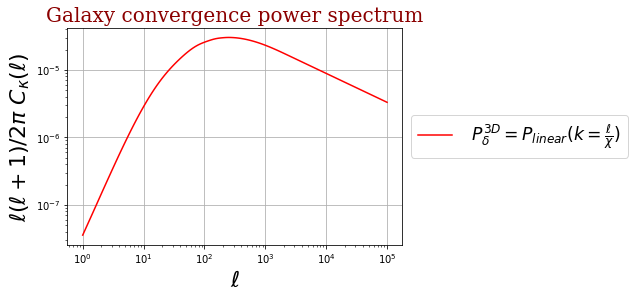

In [5]:
### CONVERGENCE PS OUTPUT ###
chiOfzT_backg, zOfchiT_backg, aOfchiT_backg = M.background(OmegaM_in, zTableChi_in) #Mod. backg
DplusOfa_linG, DplusOfchi_linG = M.Module_linG(OmegaM_in, aOfchiT_backg) #Mod. Dplus
qT_lensEff, chimaxinqT_lensEff, chiBin_lensEff = M.Module_lens_eff(zTableChi_in, aOfchiT_backg, OmegaM_in) #Mod. lens eff

CkappaT_kappaPS, chiT_out, qT_out = M.Module_Convergence_PS(inputpkT, OmegaM_in, zTableChi_in, DplusOfa_linG, aOfchiT_backg, chimaxinqT_lensEff)

## Module **Correlation functions** $\normalsize{\xi_+}$ and $\normalsize{\xi_-}$ Using Method *FFTLog*

#### Input: pkT

#### Outpus: xiPlusT_FFT_output, xiMinusT_FFT_output
$$
    \xi_+ (\theta) = \int_0^\infty \frac{\ell d\ell}{2\pi} J_0 (\ell \theta) C_\kappa (\ell), \qquad \xi_- (\theta) = \int_0^\infty \frac{\ell d\ell}{2\pi} J_4 (\ell \theta) C_\kappa (\ell).
$$

The time used to calculate A_m terms is 0.5836951732635498 s.


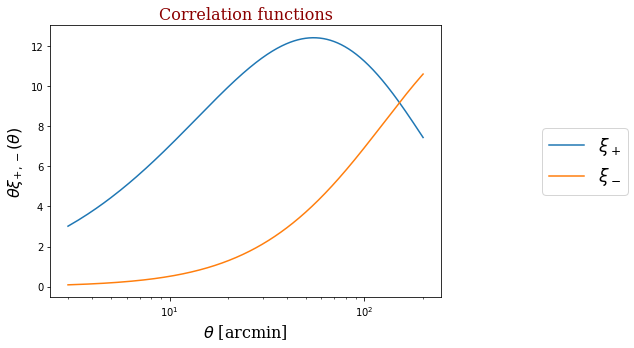

In [6]:
# Outputs
xiPlusT_FFT_output, xiMinusT_FFT_output = M.Module_FFT(inputpkT, chiOfzT_backg, chimaxinqT_lensEff, DplusOfa_linG, aOfchiT_backg, chiT_out, qT_out)